In [1]:
!pip install matplotlib tqdm opencv-python

In [2]:
#importing libraries

import os
import numpy as np
import torch
import time
import torch.utils.data
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import cv2
import glob
from PIL import Image
import ntpath
import os
from tqdm.notebook import tqdm
%matplotlib inline

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

In [3]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

lr = 0.01
epochs=5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_batch_size = 16
test_batch_size = 16

In [4]:
START_seed()
# Define your transformations (hint:use augmentations)

tranform_train = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

In [5]:
#prep the train, validation and test dataset
torch.manual_seed(2022)

data_dir = "data/"

train = CIFAR10(data_dir, train=True, download=True, transform=tranform_train)

# done for testing purpose
tr_100 = torch.utils.data.Subset(train, range(1000))

val_size = 100
train_size = len(tr_100) - val_size
train, val = random_split(tr_100, [train_size, val_size])

print(len(train), len(val))

test = CIFAR10(data_dir, train=False, download=True, transform=tranform_test)

#  train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=10, shuffle=True, num_workers=1)
val_loader = DataLoader(val, batch_size=train_batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test, batch_size=train_batch_size, shuffle=False, num_workers=8)

print(len(train_loader), len(val_loader), len(test_loader))


Files already downloaded and verified
900 100
Files already downloaded and verified
90 7 625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


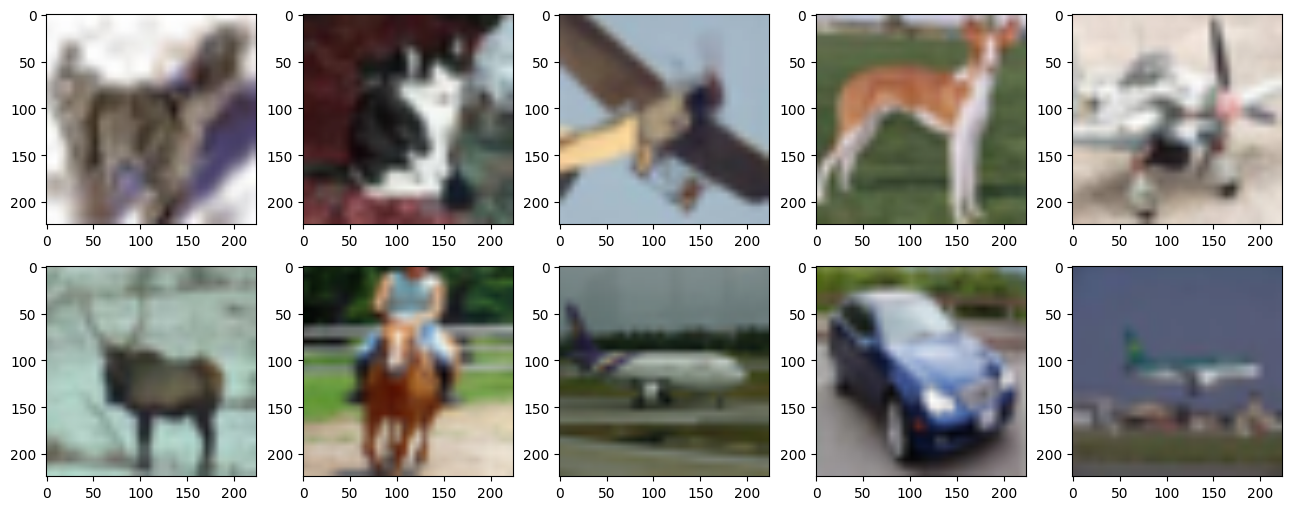

In [6]:
# show some images
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    image= image.permute(1,2,0).numpy()
    image = (image*std)+mean
    plt.imshow(image)

In [7]:
START_seed()
import torchvision.models as models

#models you can use Resnet-18, VGG-16, Resnet-50. Also dont forget to change the last layer output classes
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
#print(model)

pytorch_total_params = sum(p.numel() for p in  model.parameters())
print('Number of parameters: {0}'.format(pytorch_total_params))

Number of parameters: 11181642


/Users/sebastiancavada/anaconda3/envs/ai701/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastiancavada/anaconda3/envs/ai701/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr) 

In [9]:
# ## Creating training loop
def train(modello):    
    running_loss = 0.0    

    modello.train()

    pbar = tqdm(total=len(train_loader), dynamic_ncols=True)
    
    for batch, data in enumerate(train_loader, 0):       

        pbar.update(1)

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data        

        # zero the parameter gradients
        optimizer.zero_grad()        

        # forward + backward + optimize
        outputs = model(inputs.to(device))        
        loss = criterion(outputs, labels.to(device))     
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        
        # Postfix will be displayed on the right,
        # formatted automatically based on argument's datatype
        pbar.set_postfix(loss=running_loss/(batch+1), lr=optimizer.param_groups[0]['lr'])
       
        #print(f'[{batch + 1}, {i + 1:5d}] loss: {running_loss / (batch+1):.3f}')
        #running_loss = 0.0   

In [10]:
def validate(model):       
    running_loss = 0.0    

    model.eval()

    total = 0
    correct = 0

    tmpenum = enumerate(val_loader, 0)

    pbar = tqdm(tmpenum, total=len(val_loader))


    for i, data in tmpenum:

        pbar.update(1)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data     

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))  

        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:                                
                correct +=1            
            total+=1                       
        running_loss += loss.item()        

        pbar.set_postfix(loss=running_loss/(i+1))        

        
    print(' val loss: {:.4f} accuracy: {:.4f}'.format(loss/(i+1), 100.*correct/total))    

In [11]:
# move model to device whatever device it is
model.to(device)
start = time.time()
for epoch in range(0, epochs):
    print("Epoch number: {0}".format(epoch))
    train(model)
    validate(model)
end = time.time()
Total_time=end-start
print('Total training and inference time is: {0}'.format(Total_time))

Epoch number: 0


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 val loss: 0.2918 accuracy: 24.0000
Epoch number: 1


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 val loss: 0.2803 accuracy: 29.0000
Epoch number: 2


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 val loss: 0.2035 accuracy: 24.0000
Epoch number: 3


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 val loss: 0.2008 accuracy: 25.0000
Epoch number: 4


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 val loss: 0.2125 accuracy: 25.0000
Total training and inference time is: 412.7332239151001


In [12]:
! pip install ipywidgets
